# TOPIC MODEELING

#### References: authors of the Script (C) Elisa Michelet, and Germans Savcisens (C).
Url containing script: https://github.com/arobaselisa/industrial-west, https://github.com/carlomarxdk/topic_modelling

# 1. Import the data

In [11]:
import tomotopy as tp
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange
import spacy
import unidecode
import helpers
import nltk

In [12]:
pip install unidecode

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


The data should be a csv file containing the following columns :
- "publication_date" : date of the journal, YYYY-MM-DD
- "content" : the text in the journal

In [13]:
import pandas as pd

DATA = pd.read_csv(
    "../processedData/processedData.csv",
    sep=',',
    index_col=0
)
DATA.dropna(subset = ['processedText'], inplace = True, how='any')
DATA.reset_index(drop=True, inplace=True)
DATA.tail()
DATA.info()
KW = "electric light" # without accent
JOURNAL = "The New York Herald"
START_DATE = pd.to_datetime("1870-01-01") ## Articles on this date WILL be included
END_DATE = pd.to_datetime("1881-01-01") ## Articles on this date WON't be included 
SPACY_LANGUAGE = "en_core_web_sm" ## To change according to the corpus, french : fr_core_news_sm
COUNTRY = "US"
LANG = "en"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15198 entries, 0 to 15197
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          15198 non-null  int64 
 1   timePeriod     15198 non-null  object
 2   processedText  15198 non-null  object
dtypes: int64(1), object(2)
memory usage: 356.3+ KB


In [14]:
data = DATA
data

,index,timePeriod,processedText
0,6909,1800-01-01,wale reformation completely establish inhabita...
1,8466,1800-01-01,negro indifferent spectator process
2,4943,1800-01-01,noble talk thus recollect men many take mean s...
3,2054,1800-01-01,party give preference side yet result preferen...
4,5727,1800-01-01,gravely tell examination conduct person nation...
...,...,...,...
15193,7692,2000-01-01,see qualitative difference code extradition ac...
15194,9008,2000-01-01,many noble mention blocking lack care home cau...
15195,2769,2000-01-01,select committee note large proportion politic...
15196,3990,2000-01-01,raise issue profound importance evolve constit...


In [15]:
#data = pd.read_csv(DATA, index_col="Unnamed: 0") 
#data = pd.read_csv(DATA_PATH, index_col="id") # german ones

# 2. Data Processing

In [16]:
data["timePeriod"] = pd.to_datetime(data["timePeriod"]) #add format='%Y' for italian ones

<Axes: xlabel='timePeriod'>

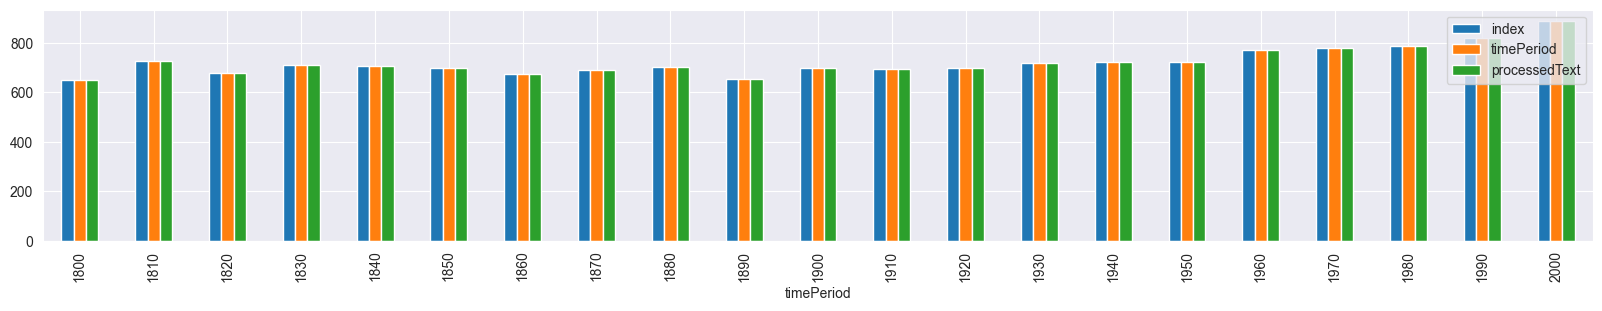

In [17]:
data.groupby(data["timePeriod"].dt.year).count().plot(kind="bar", figsize=(20, 3))

In [18]:
#data_filtered = helpers.load_preprocess_df(DATA, START_DATE, END_DATE, [KW], JOURNAL)
#data_filtered.head(3)

In [19]:
print("Lenght of FILTERED dataset:", len(data))
data.info()

Lenght of FILTERED dataset: 15198
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15198 entries, 0 to 15197
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          15198 non-null  int64         
 1   timePeriod     15198 non-null  datetime64[ns]
 2   processedText  15198 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 356.3+ KB


# 3. Topic Modelling

In [21]:
import pickle

data.rename(columns={'processedText': 'content'}, inplace=True)
_, corpus = helpers.create_corpus(data, SPACY_LANGUAGE) #.sample(5000)

with open("../processedData/corpus.pkl", 'wb') as f:
    pickle.dump(corpus, f)

Create corpus for tp model...
Runtime: 0.01 seconds || Completed: 1 of 15198
Runtime: 2.16 seconds || Completed: 501 of 15198
Runtime: 4.59 seconds || Completed: 1001 of 15198
Runtime: 6.52 seconds || Completed: 1501 of 15198
Runtime: 8.33 seconds || Completed: 2001 of 15198
Runtime: 10.22 seconds || Completed: 2501 of 15198
Runtime: 12.04 seconds || Completed: 3001 of 15198
Runtime: 13.78 seconds || Completed: 3501 of 15198
Runtime: 15.59 seconds || Completed: 4001 of 15198
Runtime: 17.38 seconds || Completed: 4501 of 15198
Runtime: 19.24 seconds || Completed: 5001 of 15198
Runtime: 21.20 seconds || Completed: 5501 of 15198
Runtime: 22.97 seconds || Completed: 6001 of 15198
Runtime: 24.85 seconds || Completed: 6501 of 15198
Runtime: 27.07 seconds || Completed: 7001 of 15198
Runtime: 30.10 seconds || Completed: 7501 of 15198
Runtime: 32.05 seconds || Completed: 8001 of 15198
Runtime: 33.65 seconds || Completed: 8501 of 15198
Runtime: 35.22 seconds || Completed: 9001 of 15198
Runtime: 3

In [23]:
import pickle

with open('../processedData/corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)

In [24]:
############################################
###### You should change only this
k1_max = 3 ###(min 1) if k1_max - 1 == best k1
k2_max = 25
### k2 should always be higher than k1 (min 1)
####################
params = []
scores = []
num_iter = 0
max_iter = 0
for k1 in range(1, k1_max):
    for k2 in range(k1,k2_max):
        max_iter +=1
        
start = time.time()
for k1 in range(1, k1_max):
    for k2 in range(k1,k2_max):
        num_iter+=1
        model = tp.PAModel(tw=tp.TermWeight.IDF, min_df=10, rm_top=10, k1=k1, k2=k2, corpus=corpus, seed=0)
        model.train(500, workers=1)
        score = tp.coherence.Coherence(model, coherence="c_v").get_score() #try with 'u_mass' instead of 'c_v' 
        params.append((k1,k2))
        scores.append(score)
        print("Runtime: %.2f seconds" %(time.time() - start), "|| Number of Searches: %s out of  %s" %(num_iter, max_iter))

Runtime: 12.96 seconds || Number of Searches: 1 out of  47
Runtime: 33.05 seconds || Number of Searches: 2 out of  47
Runtime: 51.69 seconds || Number of Searches: 3 out of  47
Runtime: 75.69 seconds || Number of Searches: 4 out of  47
Runtime: 103.19 seconds || Number of Searches: 5 out of  47
Runtime: 133.06 seconds || Number of Searches: 6 out of  47
Runtime: 163.86 seconds || Number of Searches: 7 out of  47
Runtime: 192.99 seconds || Number of Searches: 8 out of  47
Runtime: 227.40 seconds || Number of Searches: 9 out of  47
Runtime: 271.66 seconds || Number of Searches: 10 out of  47
Runtime: 318.82 seconds || Number of Searches: 11 out of  47
Runtime: 366.47 seconds || Number of Searches: 12 out of  47
Runtime: 422.17 seconds || Number of Searches: 13 out of  47
Runtime: 481.22 seconds || Number of Searches: 14 out of  47
Runtime: 531.81 seconds || Number of Searches: 15 out of  47
Runtime: 576.73 seconds || Number of Searches: 16 out of  47
Runtime: 643.83 seconds || Number of 

(BEST MODEL) k1=2 k2=11 coherence=0.55


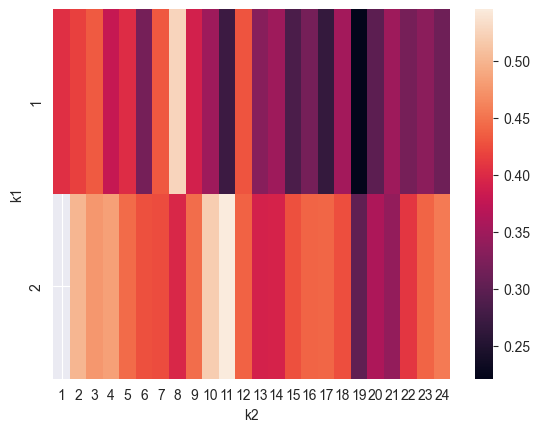

In [25]:
best_params = np.argmax(scores)
print("(BEST MODEL) k1=%s k2=%s coherence=%.2f"  %(params[best_params][0], params[best_params][1],  scores[best_params]))

data = pd.DataFrame(data={'k1':list(zip(*params))[0], 'k2':list(zip(*params))[1], 'score':scores})
data = data.pivot(index='k1', columns='k2', values='score')
sns.heatmap(data)
plt.show()

**1. Choose the best parameters**

In [26]:
#################################################
### Set the best model
best_k1 = params[best_params][0] 
best_k2 = params[best_params][1]
model = tp.PAModel(tw=tp.TermWeight.IDF, min_cf=5, k1=best_k1, k2=best_k2, corpus=corpus, seed=0)
model.burn_in=100
model.train(1000, workers=1)

**2. Print all the topics**

In [ ]:
#############################################
#### Topics gonna be here 
for k in range(best_k2):
    print('Topic #{}'.format(k))
    print("\t", [w for w, _ in model.get_topic_words(k)])


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for k in range(model.k):
    ts = model.get_topic_time_series(k)
    ax.plot(ts, label=f"Topic {k}")

ax.set_xlabel("Time")
ax.set_ylabel("Frequency")
ax.legend()

plt.show()
